Predicting Penguin Species in the Palmer Archipelago

Introduction
Background Information: The Antarctic region, which is characterized by its extreme climate, is a critical habitat for penguins. The dataset that is used in this project is collected in the Palmer Archipelago, which is situated off the western coast of the Antarctic Peninsula, and hosts three species of penguin. 

Research Question: The research question this project is going to answer is how to predict the species of penguin based on their culmen length (mm), culmen depth (mm), flipper length (mm), and body mass (g). To answer the research question, we utilize a comprehensive dataset containing information on the three penguin species which are Chinstrap, Adélie, and Gentoo.

Description of the Dataset: This dataset, carefully collected and made available by Dr. Kristen Gorman and the Palmer Station, Antarctica LTER, a member of the Long Term Ecological Research Network, provides valuable insights into the ecological and morphological characteristics of penguin populations (Gorman 2014).

In [1]:
install.packages("kknn")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [2]:
#install these libraries 
library(tidyverse) 
library(dplyr)
library(tidymodels)
library(kknn)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks read

In [3]:
#download and read data
download.file("https://raw.githubusercontent.com/matthewsans/DCSI-100-group-project/main/penguins_lter.csv", "penguins")
penguin_data <- read_csv("penguins")
head(penguin_data)


Rows: 344 Columns: 17
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (10): studyName, Species, Region, Island, Stage, Individual ID, Clutch C...
dbl  (7): Sample Number, Culmen Length (mm), Culmen Depth (mm), Flipper Leng...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


studyName,Sample Number,Species,Region,Island,Stage,Individual ID,Clutch Completion,Date Egg,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo),Comments
<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>
PAL0708,1,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N1A1,Yes,11/11/07,39.1,18.7,181,3750,MALE,NA,NA,Not enough blood for isotopes.
PAL0708,2,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N1A2,Yes,11/11/07,39.5,17.4,186,3800,FEMALE,8.94956,-24.69454,NA
PAL0708,3,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N2A1,Yes,11/16/07,40.3,18.0,195,3250,FEMALE,8.36821,-25.33302,NA
PAL0708,4,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N2A2,Yes,11/16/07,NA,NA,NA,NA,NA,NA,NA,Adult not sampled.
PAL0708,5,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N3A1,Yes,11/16/07,36.7,19.3,193,3450,FEMALE,8.76651,-25.32426,NA
PAL0708,6,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N3A2,Yes,11/16/07,39.3,20.6,190,3650,MALE,8.66496,-25.29805,NA


In [4]:
#Wrangle and clean data
names(penguin_data)[13] <- "body_mass"
names(penguin_data)[2] <- "sample_number"
names(penguin_data)[10] <- "culmen_length"
names(penguin_data)[11] <- "culmen_depth"
names(penguin_data)[12] <- "flipper_length"
names(penguin_data)[13] <- "body_mass"
names(penguin_data)[3] <- "species"
names(penguin_data)[4] <- "region"
names(penguin_data)[5] <- "island"

clean_penguin <- select(penguin_data, c(species, region, island, culmen_length, culmen_depth, flipper_length, body_mass))
clean_penguin <- clean_penguin |> mutate(species = as.factor(species)) |>
    select(-region)
    
head(clean_penguin)

#Split data for exploring and training
set.seed(1234)
split_penguin <- initial_split(clean_penguin, prop = 0.75, strata = species)
penguin_training <- training(split_penguin)  # USE FOR DATA VISUALATION/TRAINING
penguin_testing <- testing(split_penguin)    # DO NOT USE UNTIL FINAL TEST

species,island,culmen_length,culmen_depth,flipper_length,body_mass
<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Adelie Penguin (Pygoscelis adeliae),Torgersen,39.1,18.7,181,3750
Adelie Penguin (Pygoscelis adeliae),Torgersen,39.5,17.4,186,3800
Adelie Penguin (Pygoscelis adeliae),Torgersen,40.3,18.0,195,3250
Adelie Penguin (Pygoscelis adeliae),Torgersen,NA,NA,NA,NA
Adelie Penguin (Pygoscelis adeliae),Torgersen,36.7,19.3,193,3450
Adelie Penguin (Pygoscelis adeliae),Torgersen,39.3,20.6,190,3650


species,mean_culmen_length,mean_culmen_depth,mean_flipper_length,mean_body_mass
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
Adelie Penguin (Pygoscelis adeliae),38.83097,18.35575,190.0619,3700.442
Chinstrap penguin (Pygoscelis antarctica),48.75882,18.38627,195.8235,3734.314
Gentoo penguin (Pygoscelis papua),47.28602,14.98710,217.1290,5063.172


Warning message:
“Removed 1 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 1 rows containing missing values (`geom_point()`).”


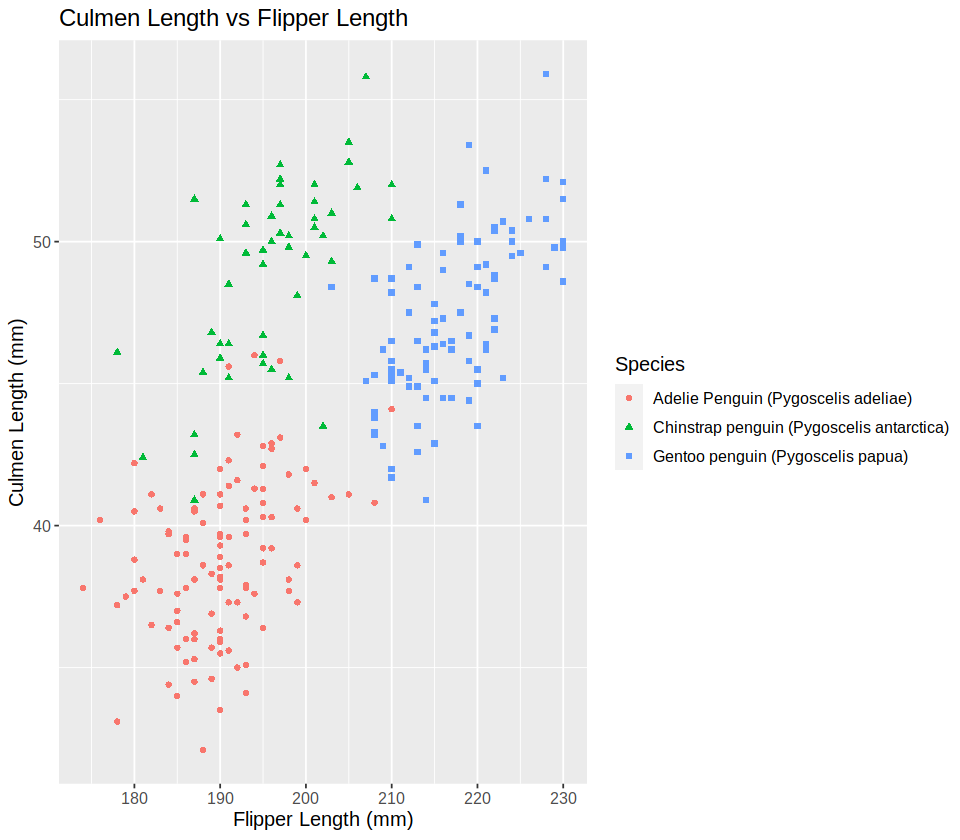

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 1 rows containing non-finite values (`stat_bin()`).”


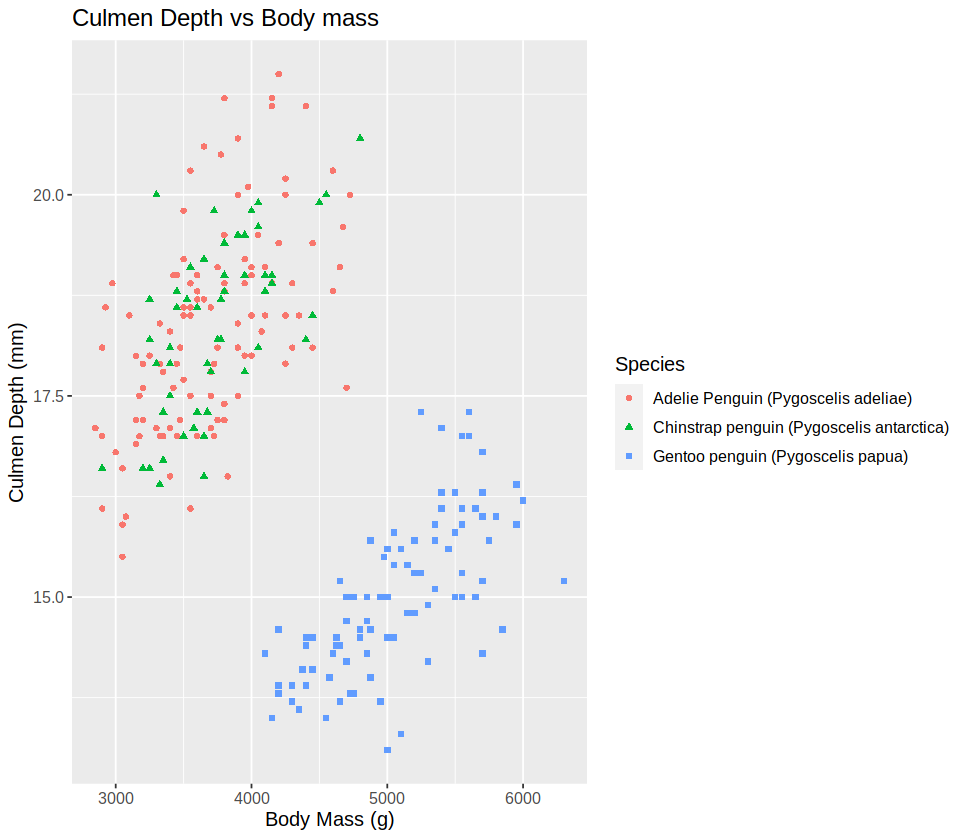

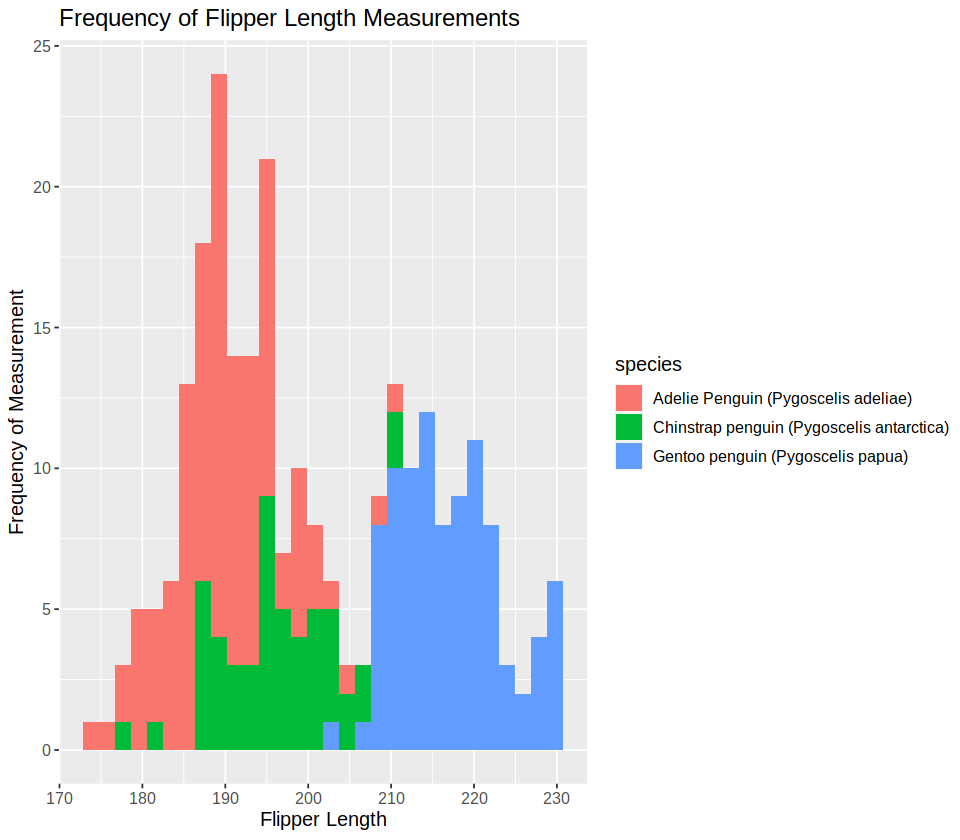

In [5]:
#exploratory data analysis
penguin_mean <- penguin_training |>
      group_by(species) |>
      summarize(across(culmen_length:body_mass, \(x) mean(x, na.rm = TRUE)))
colnames(penguin_mean)[2:5] <- c("mean_culmen_length", "mean_culmen_depth", "mean_flipper_length", "mean_body_mass")
penguin_mean

#Visualization

options(repr.plot.width = 8, repr.plot.length = 2)
penguin_visual1 <- ggplot(penguin_training, aes(y = culmen_length, x = flipper_length, color = species, shape = species)) +
    geom_point() + 
    labs(y = "Culmen Length (mm)", x = "Flipper Length (mm)", color = "Species", shape = "Species") +
    ggtitle("Culmen Length vs Flipper Length") +
    theme(text = element_text(size = 12)) 
penguin_visual2 <- ggplot(penguin_training, aes(y = culmen_depth, x = body_mass, color = species, shape = species)) +
    geom_point() + 
    labs(y = "Culmen Depth (mm)", x = "Body Mass (g)", color = "Species", shape = "Species") +
    ggtitle("Culmen Depth vs Body mass") +
    theme(text = element_text(size = 12)) 
penguin_visual3 <- ggplot(penguin_training, aes(x = flipper_length, fill = species)) +
    geom_histogram() +
    labs(y = "Frequency of Measurement", x = "Flipper Length", title = "Frequency of Flipper Length Measurements") +
    theme(text = element_text(size = 12)) 



penguin_visual1
penguin_visual2
penguin_visual3

In [7]:
# we need to make a model
#kkn_spec <- knn(

new_penguin_train <-  penguin_training |>
    mutate(island = as.numeric(as.factor(island)))
new_penguin_plot <- ggplot(new_penguin_train, aes(x = island, colour = species)) +
                           geom_bar()
k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 5))

penguin_vfold <- vfold_cv(new_penguin_train, v = 5, strata = species)

penguin_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

penguin_recipe <- recipe(species ~ ., data = new_penguin_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

penguin_fit <- workflow() |>
    add_recipe(penguin_recipe) |>
    add_model(penguin_spec) |>
    tune_grid(resamples = penguin_vfold, grid = k_vals ) |>
    collect_metrics()
penguin_fit

    


x Fold5: preprocessor 1/1, model 1/1 (predictions):
  Error in `mutate()`:
  ℹ In argument: `.row = orig_rows`.
  Caused by error:
  ! `.row` must be size 49 or 1, not 50.



neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.9902903,4,0.0056063992,Preprocessor1_Model01
1,roc_auc,hand_till,0.9910326,4,0.0059265717,Preprocessor1_Model01
6,accuracy,multiclass,0.9901961,4,0.0098039216,Preprocessor1_Model02
6,roc_auc,hand_till,1.0000000,4,0.0000000000,Preprocessor1_Model02
11,accuracy,multiclass,0.9854791,4,0.0093561128,Preprocessor1_Model03
11,roc_auc,hand_till,1.0000000,4,0.0000000000,Preprocessor1_Model03
16,accuracy,multiclass,0.9903811,4,0.0055555521,Preprocessor1_Model04
16,roc_auc,hand_till,1.0000000,4,0.0000000000,Preprocessor1_Model04
21,accuracy,multiclass,0.9952830,4,0.0047169811,Preprocessor1_Model05


Methods:
The first step in our project is the Data Splitting. We will divide the penguin dataset into two subsets which are a training set and a testing set. We are planning to use a split ratio of 75:25. The second step is the variable selection, we will select the relevant features, culmen length, culmen depth, flipper length, and body mass for prediction. The third step is the KNN Model Building. We will specify a KNN model for classification and train the KNN model using our training set. Then we will use cross-validation to find the optimal value of k. The fourth step is the Model Evaluation. We will use the testing data to evaluate the KNN model’s performance. The following classification performance metrics will be calculated to measure the performance of our model, Accuracy (to measure the overall model accuracy in predicting penguin species), Confusion Matrix (to assess the number of true positives and negatives, as well as false positives and negatives), Precision and Recall. The final step is the Visualization. We will visualize our result using multivariate histogram charts. We will plot the different variables individually on histogram charts and color the bars to represent the count from each penguin species. Then, we will line the charts up in a grid so they are easier to read.

Expected outcomes and significance:
We expect to find that some penguin species typically have certain traits. For example, maybe one of the penguin species typically has the shortest culmen length. These findings could lend insight into the penguins evolution process. If we look at specific traits that have been developed over millions of years, we could perhaps get a better picture of what the world was like when they were evolving through the specific traits they developed. This could lead to future questions involving why certain penguin species developed differently than other penguin species and, in a similar vein, questions about where they will go from here.

Data citations:

Gorman, K. B., Williams, T. D., & Fraser, W. R. (2014). Ecological sexual dimorphism and environmental variability within a community of antarctic penguins (Genus      Pygoscelis). PloS One, 9(3), e90081–e90081. https://doi.org/10.1371/journal.pone.0090081
